### 1.2- Configuration Setup:

Configuration parameters will be loaded dynamically from a JSON file. This ensures that all subject-specific and dataset-specific information is managed externally, supporting full reusability and transparency.

*You will provide the JSON configuration file details later. The notebook will be ready to load and use it as soon as it's available.*

## Step 1: Import Libraries and Set Up Modular Functions

All imports and configurations in this notebook are designed to be dynamic and modular. No subject-specific or hard-coded values are used, ensuring scientific reproducibility and easy adaptation to new datasets.

# MEG Data Preprocessing Pipeline - Subject 02

## Overview
This notebook implements a step-by-step, interpretable, and reusable preprocessing pipeline for OPM-MEG data analysis. The approach is designed for scientific research and avoids hard-coded values, making it adaptable for different datasets and subjects.

## Research Context
- **Subject**: sub-02
- **Data Type**: OPM-MEG recordings (.lvm format)

## 1- Preprocessing Steps
The pipeline will guide you through library imports, configuration loading, and file path setup.

### 1.1- Libraries:

Import all required libraries and custom functions. The notebook will use modular imports to ensure reusability and clarity.

In [14]:
# ---- LIBRARIES ----
import json
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA

# Add source directory to path for custom functions
sys.path.append('../source')

# Import custom functions (modular, not hard-coded for subject)
from find_paths import get_onedrive_path
from config_manager import (load_and_display_config,
                             validate_file_selection, 
                             preview_file_header,
                             extract_sample_interval,
                             preprocess_meg_data)
from plot_functions import plot_channels_comparison


### 1.2- Load configuration:

In [15]:
# ---- LOAD CONFIGURATION ----

SUBJECT_ID = "sub-02"
CONFIG_VERSION = "Version-1"

config = load_and_display_config(SUBJECT_ID, version=CONFIG_VERSION)

Configuration loaded for sub-02
SELECTABLE PARAMETERS:
DATA_TYPES: ['source_data']
SETUPS: ['MED', 'NO_MED']
CONDITIONS:
  MED: ['Move', 'Rest']
  NO_MED: ['Move', 'Rest']


### 1.3- Path Setup:

In [16]:
# ---- PATH SETUP ----

base_data_path = get_onedrive_path('data')
print("Base data path found successfully")
print(f"Base path: {base_data_path}")

# ---- FILE SELECTION ----

print("\n" + "="*60)
print("Based on the available options above, define your selection:")

# USER DEFINES THESE PARAMETERS:
DATA_TYPE = "source_data" 
SETUP = 'NO_MED'  # "MED" or "NO_MED"
CONDITION = config["conditions"][SETUP][0]  # "Move" or "Rest"
TIME_POINT = config["time_points"][0]  # select a number from -1 to 7 (0 excluded)

print(f"\nSelected: {SETUP} -> {CONDITION} -> {TIME_POINT}")

# Validate selection and construct filename using config
filename, path_info = validate_file_selection(config, DATA_TYPE, SETUP, CONDITION, TIME_POINT)


# Construct complete file path using ALL config parameters
file_path = os.path.join(
    base_data_path,
    config["data_path"],
    filename
)

print(f"Selected file: {filename}")
print(f"Full file path: {file_path}")
print(f"File exists: {os.path.exists(file_path)}")

project folder found: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG
Base data path found successfully
Base path: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG/data

Based on the available options above, define your selection:

Selected: NO_MED -> Move -> -1
Selected file: sub02-NO_MED-Move_-1.lvm
Full file path: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG/data/source_data/sub-02/plfp65/sub02-NO_MED-Move_-1.lvm
File exists: True


In [17]:
#---- READING FILE INFO ----

preview_file_header(file_path, num_lines=27)


Preview of the first 27 lines in file:
LabVIEW Measurement
Writer_Version	2
Reader_Version	2
Separator	Tab
Decimal_Separator	.
Multi_Headings	No
X_Columns	One
Time_Pref	Absolute
Operator	Neuro1
Date	2024/11/13
Time	12:44:10.1353811994194984436
***End_of_Header***

Channels	224
Samples	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16	16
Date	2024/11/13	2024/11/13	2024/11/13	202

### LabVIEW Measurement (.lvm) File Structure Summary

- **File Type:** LabVIEW Measurement (.lvm)
- **Channels:** 224 total, but we consider only the MEG components (X, Y, Z)
- **Sampling Rate:** ~375 Hz (`Delta_X = 0.002667 s`)
- **Units:** Most channels in picoTesla (`pT`)
- **Time Stamps:** Absolute time for each sample
- **Data Columns:** Labeled as X1–X64, Y1–Y64, Z1–Z64


In [18]:
# ---- DEFINE CONSTANT VARIABLES ----

df = pd.read_csv(file_path, sep='\t', skiprows=22)


TIME_INTERVAL = extract_sample_interval(file_path) # = 0.002667 s
SAMPLE_FREQ = round(1 / TIME_INTERVAL) # = 375 Hz
MEG_TIME = df['X_Value']

# Define MEG channel lists (we consider the first 20 channels)
MEG_X_CHANNELS = [f"X{i}" for i in range(1, 21)]
MEG_Y_CHANNELS = [f"Y{i}" for i in range(1, 21)]
MEG_Z_CHANNELS = [f"Z{i}" for i in range(1, 21)]

# Extract MEG components as DataFrames
MEG_X = df[MEG_X_CHANNELS]
MEG_Y = df[MEG_Y_CHANNELS]
MEG_Z = df[MEG_Z_CHANNELS]

# ---- BASIC DATA INFORMATION ----

print("Basic MEG Data Information")
print("="*40)
print(f"Data shape: {df.shape}")
print(f"Number of MEG channels (X): {len(MEG_X_CHANNELS)}")
print(f"Number of MEG channels (Y): {len(MEG_Y_CHANNELS)}")
print(f"Number of MEG channels (Z): {len(MEG_Z_CHANNELS)}")
print(f"Number of time points: {len(MEG_TIME)}")
print(f"Sampling frequency: {SAMPLE_FREQ} Hz")
print(f"Duration: {MEG_TIME.iloc[-1] - MEG_TIME.iloc[0]:.2f} seconds")

Basic MEG Data Information
Data shape: (137040, 226)
Number of MEG channels (X): 20
Number of MEG channels (Y): 20
Number of MEG channels (Z): 20
Number of time points: 137040
Sampling frequency: 375 Hz
Duration: 365.44 seconds


## 2- Preprocessing Pipeline

The original sampling frequency of the OPM-MEG data is **375 Hz**, as determined from the file header (`Delta_X = 0.002667 s`).  
Since this frequency is already suitable for MEG analysis and does not match common downsampling targets (such as 512 Hz), I will **retain the original sampling frequency** for all preprocessing steps.  
No upsampling or downsampling will be performed.

---

### Filtering Pipeline

The following filtering steps will be applied to the MEG data:

- **Bandpass filter:** 1–100 Hz (to retain relevant MEG frequencies)
- **Notch filter:** 50, 100, 150 Hz (to remove line noise and harmonics)

These filters will be applied directly to the data using the original sampling frequency.

---

#### 2.1- First it's necessary to convert the file to mne RawArray in order to use then mne functions.

In [19]:
# Combine all MEG channels (X, Y, Z)
ALL_MEG_CHANNELS = MEG_X_CHANNELS + MEG_Y_CHANNELS + MEG_Z_CHANNELS
MEG_ALL = df[ALL_MEG_CHANNELS]

# Create MNE info and Raw object
info_MEG = mne.create_info(
    ch_names=ALL_MEG_CHANNELS,
    sfreq=SAMPLE_FREQ,
    ch_types=['mag'] * len(ALL_MEG_CHANNELS)
)
raw_MEG = mne.io.RawArray(MEG_ALL.values.T, info_MEG, verbose=False)


#### 2.2- Filtering Pipeline:

In [20]:
# ---- FILTERING PIPELINE ----

# Filtering parameters 
BANDPASS_LOW = 1
BANDPASS_HIGH = 100
NOTCH_FREQS = [50, 100]

# Apply bandpass filter
raw_MEG.filter(
    l_freq=BANDPASS_LOW,
    h_freq=BANDPASS_HIGH,
    verbose=False
)

# Apply notch filter
raw_MEG.notch_filter(
    freqs=NOTCH_FREQS,
    verbose=False
)

<RawArray | 60 x 137040 (365.4 s), ~62.8 MiB, data loaded>

#### Plot Parameters set up:

In [50]:
# ---- SETTING UP PLOTTING PARAMETERS ----

# Determine number of MEG channels and their names
NUM_MEG_CHANNELS = len(MEG_X_CHANNELS)
MEG_CHANNEL_NAMES = ALL_MEG_CHANNELS

# Adapt the data for the plot requirements:
raw_X_data = MEG_X.values.T  # shape: channels x time
filtered_X_data = raw_MEG.get_data(picks=MEG_X_CHANNELS)  # shape: channels x time


# Colors for plotting (distinct for each channel)
COLORS = plt.cm.tab20(np.linspace(0, 1, NUM_MEG_CHANNELS))

### 2.3- Plot the raw channel per component:

The aim is to detect which are the bad channels from the entire timeseries plot

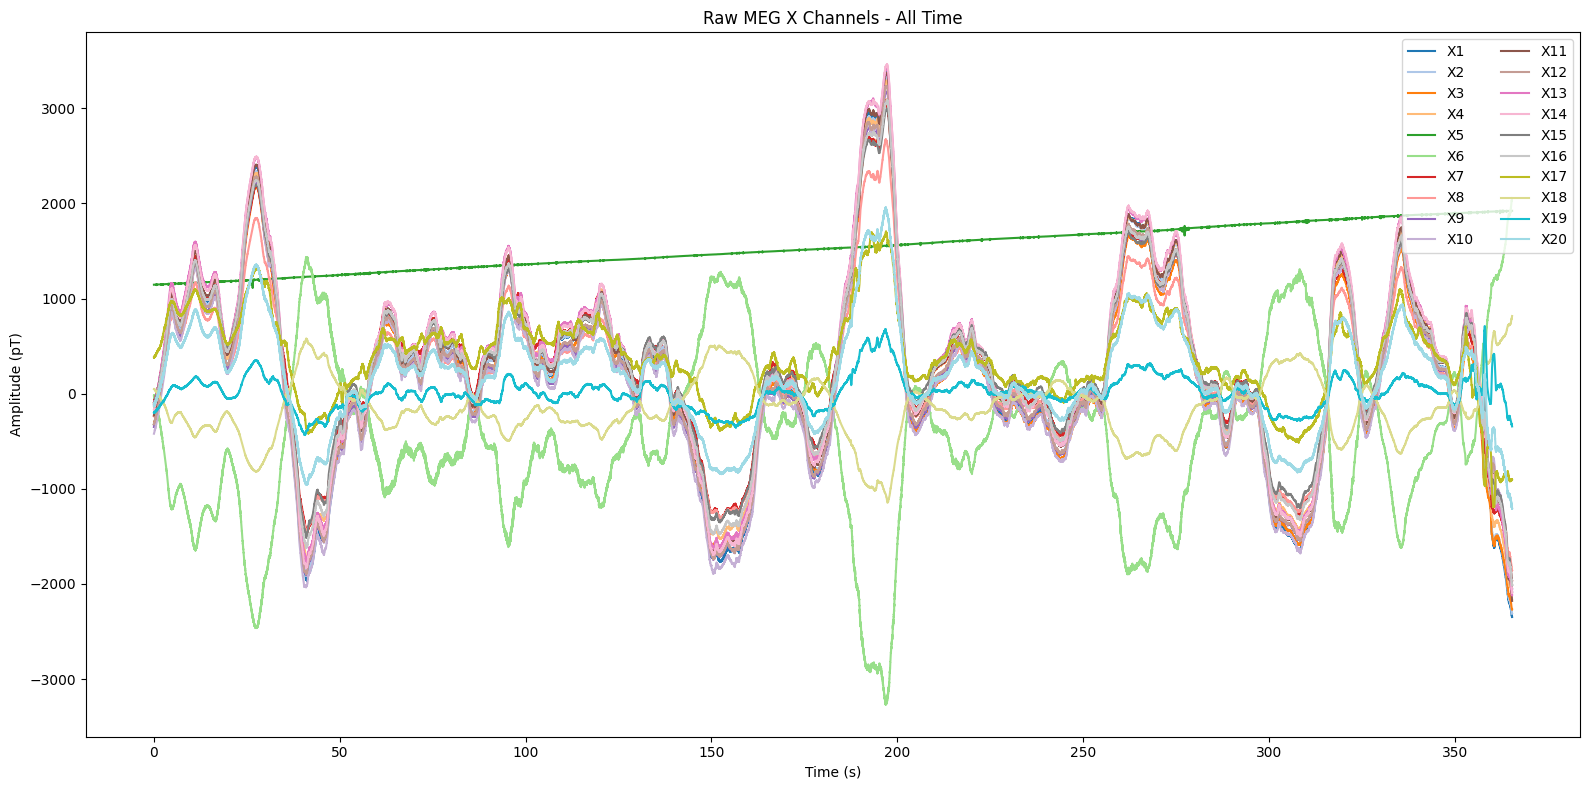

In [52]:
plt.figure(figsize=(16, 8))
for i, channel in enumerate(MEG_X_CHANNELS):
    plt.plot(MEG_TIME, raw_X_data[i], label=channel, color=COLORS[i])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (pT)")
plt.title("Raw MEG X Channels - All Time")
plt.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.show()

### 2.4- Compare raw vs filtered:

- **First plot on the entire time series**
- **Second one on a shorter time window**

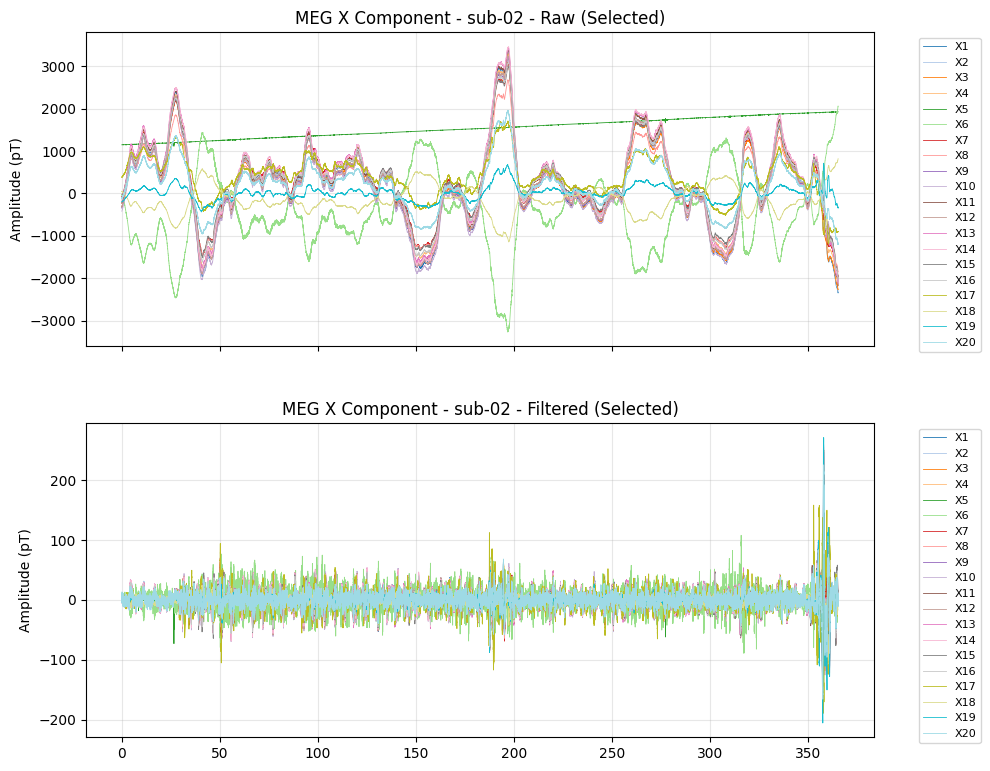

In [53]:
plot_channels_comparison(
    time_0=MEG_TIME,
    time_1=MEG_TIME,
    raw_channels=raw_X_data,
    filtered_channels=filtered_X_data,
    raw_labels=MEG_X_CHANNELS,
    filtered_labels=MEG_X_CHANNELS,
    colors=COLORS[:len(MEG_X_CHANNELS)],
    rec_label="sub-02",
    y_label="Amplitude (pT)",
    axis_label="X",
    sync_ylim=False
)